<a href="https://colab.research.google.com/github/ruperty/colab/blob/master/learning_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartpole Reorganisation

Two previous demos ([Basic Cartpole](https://colab.research.google.com/github/ruperty/colab/blob/master/basic_cartpole.ipynb) , [Moving Cartpole](https://colab.research.google.com/github/ruperty/colab/blob/master/moving_cartpole.ipynb)) showed how the Cartpole scenario could be controlled and moved around with a simple hierarchy of about 4 or 5 levels. Each level has a single weight (gain) value which governs the performance of the control system.

Previously those weights were chosen by hand, so may not necessarily be the best. This current demo shows how those weights can be automatically optimised by a process of reorganisation (learning). In this case, reorganisation means changing the weight values based upon the global error within the system to improve performance. The global error encapsulates all the errors within each control system in the hierarchy. The lower this error then the more stable is the control of the Cartpole. 

As explained in the Advanced section, in this demo, this is achieved by implementing a PCT hierarchy within Tensorflow, the Deep Learning framework.

However, before going in to details let's first see it running. 

## Imports
If you were to run this demo in your own desktop Python environment you would be able to see the Cartpole run live. However, due to the limitations of the online system it is necessary to create a video of the Cartpole environment and run that after the event. 

So, to support that we need these first two cells, which would not be required in your local environment.

In [2]:
# install of utilities to display openai environment in video
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils  > /dev/null 2>&1

In [3]:
#import sys
from gym.wrappers import Monitor
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start() 

You would need these two, to import some standard libraries and my own functions.

In [4]:
# install of my own pct library
!git clone https://github.com/ruperty/pct.git

Cloning into 'pct'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 439 (delta 260), reused 294 (delta 118), pack-reused 0
Receiving objects: 100% (439/439), 157.14 KiB | 442.00 KiB/s, done.
Resolving deltas: 100% (260/260), done.


In [5]:
import plotly.graph_objects as go
import pct.openai.cpplots as cp
from pct.dl.models.cartpole import CartpoleTuning

A few settings.

In [6]:
training=True
#render_gym=True
batch_size=10
num_runs=2000
learning_rate=0.0005

# initial weights/gains
weights=[4,       1.8,       1.5,       -0.05]

Create the Cartpole hierarchy. See Advanced section for visualisation of the (Tensorflow) model. 

In [15]:
ct = CartpoleTuning( env_name="CartPole-v1", video_wrap=True)
env = ct.get_env()
obs = env.reset()
print("Initial inputs pole angle, pole velocity, cart position, cart velocity", obs)

Initial inputs pole angle, pole velocity, cart position, cart velocity [ 0.00403741 -0.01518974  0.0209819  -0.0033187 ]


Configure the learning aspects of the model. This uses an optimisation algorithm called RMSProp and a "loss" function, which in this case is the root of the sum of the squares of the errors (RSuSE).  That is, squaring each of the four errors adding them up and then taking the square root. The loss value actually used for optimisation is the moving average of the loss. 

In [16]:
ct.configure(weights=weights, opt_type="rmsprop", learning_rate=learning_rate, loss_type="rsuse",  loss_smooth=0.9, print=100, num_runs=num_runs)
ct.display_configure()

## Training
That's all the set up, now run the system and see the training reorganise the weights of the Cartpole model to optimise the control.

In [17]:
out = ct.run( batch_size, training) 

                                   Weights 
Step  Loss    pole_angle pole_velocity cart_position cart_velocity  
 100  0.408      4.016        1.760        1.459        -0.050       
 200  0.396      4.021        1.722        1.420        -0.050       
 300  0.552      4.037        1.683        1.381        -0.050       
 400  0.372      4.056        1.646        1.344        -0.050       
 500  0.709      4.072        1.606        1.303        -0.050       
 600  0.453      4.076        1.568        1.264        -0.050       
 700  0.514      4.083        1.528        1.225        -0.050       
 800  0.314      4.101        1.493        1.189        -0.050       
 900  0.466      4.109        1.453        1.149        -0.050       
1000  0.332      4.113        1.414        1.110        -0.050       
1100  0.307      4.122        1.376        1.071        -0.050       
1200  0.276      4.127        1.337        1.033        -0.050       
1300  0.253      4.138        1.299        0.99

## Video
Watch the video.

In [20]:
# For some reason it is necessary to run this cell twice, haven't worked out why yet.
import pct.openai.video as vid
ct.show_video()
#vid.show_video()

Now plot the global error over the period of the Cartpole run.

In [13]:
import numpy as np
data = ct.get_error_data()
data = [data[0], np.clip(data[1], 0, 1)]
cp.scatter_plot(data , "Global Error", "Time", "Error")

As you can see the error has reduced somewhat, to improve control. However, not by that much. Also, as you probably noticed, the system fails towards the end of the run as the error goes off the scale. 

The reasons for both of these are explained in the next section when you look at the 3D visualisation of the landscape of the error based on the weight values.  

# Advanced


## Tensorflow

Tensroflow (https://www.tensorflow.org/) is Google's very sophisticated Deep Learning platform for imlplementing Neural Networks.

It is based on the principle of Graph Computation. This means that the processing is separated into separate nodes which are linked together. The node structure allows for highly-distributed systems, across threads/processors or even remote computers as different nodes can be processed at the same time. This parallelism results in highly-efficient processing which is crucial for the enormous computational demands of big data neural networks.

The graph structure is designed so as to fit with the structure of neural networks, that deal with layers of neuron-like processing units. That graph structure is also very well suited to Perceptual Control hierarchies, which, similarly, consists of layers of neuron-like (control) units.

However, there is one major difference which is that the whole philosophy of neural networks (and Artificial Intelligence generally) is of an open-loop processing pipeline from inputs, through the layers, to the outputs. 

Within neural networks there is no concept of continuous feedback dynamically affecting the inputs. 

The architecture of Tensorflow has been designed and implemented with that philosophy in mind and, therefore, does not readily support dynamic, immediate feedback.

Fortunately though, I have managed to hack the standard procedures to construct custom processing and training loops so that the outputs at each step are able to feed back through the model environment to dynamically change the inputs that are "perceived".

## The Model

Tensrflow includes some very useful visualisation functionality. The next cell, shows one, which is the visualisation of the neural network graph, of layers.

This is the above implementation of the PCT Cartpole system. 

Each node is a layer of "neurons" and the links are the connections between the neurons in one layer and another. Typically, each node in a neural network might involve dozens or hundreds of of neurons and connections.

In this case, though, each node is just a single neuron and the links are a single connection. So, PCT provides a very parsimonious implementation of a neural network that can control the Cartpole.

Each layer computes the difference between the desired and actual input (percpeption) resulting in the layer "error". The error along with a weight (gain) defines the desired (reference) input at the next layer.

The main output of this network, for training purposes, is each of the errors, in contrast to standard neural networks which is normally the prediction (or label) of what the input should be. These errors are used to adjust (train) the network weights in order to improve performance; reduce the error.

A traditional Reinforcement Learning neural network implementation of the Cartpole system is likely to have over 1,000 trainable parameters (weights). This PCT implementation has just four!

There is one other output of this network and that is the lowest level (weighted) error which varies continuously and upon which the "action" is based that is fed back into the Cartpole environment determining the direction in which to move the cart.  

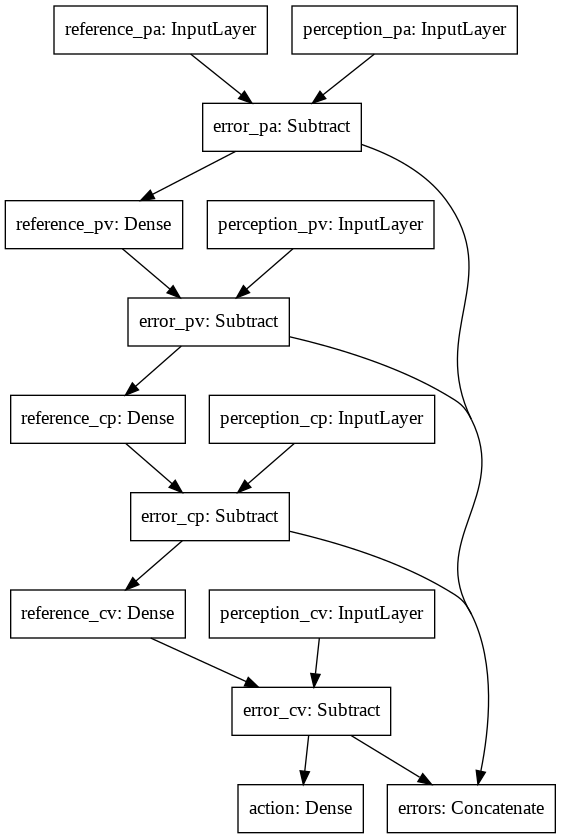

In [ ]:
ct.plot_model("pct-cartpole-model.png")
ct.close()       
from IPython.display import Image, display
Image("pct-cartpole-model.png")

## Error Landscape

The 3-dimensional plot below shows the error landscape based upon the wieghts of the control units in the PCT Cartpole implementation. 

The plot is **interactive** so you can rotate the landscape, zoom in and hover to display the values.

The x and y axes show, respectively, the two weights at the top of the hierarchy, for pole angle and pole velocity. 

The z axis is the global error of the system. The areas where z is zero are actually very high error, but are shown as zero to make the landscape easier to visualise.

As you can see error slopes down to a minimum where pa=2.5 and pv=0.5. Lower than that though the error falls off a cliff, or, rather, falls up a cliff. That is, after that point the system becomes unstable and fails.

And that is why the training above suddenly fails after a period of improvement. 

So, for this scenario at least, it is not sufficient just to throw an optimisation algorithm at the problem due to the severe disconuities in the error value as a result of small changes in the weights. 

To find the optimal values for the weights it is also necessary to understand the error landscape.

In [ ]:
cp.load_3d_landscape("pct/data/data-papv-[[00.0][10.0]-[00.0][02.0]]-cp-2.0.npy", 2.5)

# Comments

Strangely, when I first implmented this Cartpole model in Tensorflow I had got the order of the perceptions wrong, but was actually getting better control than above (error of about ~0.15). The order, from the top level, was cp, cv, pa, pv rather than pa, pv, cp, cv.

When I noticed this I was, at first, surprised that it was working at all, then  realised that as the steady-state reference at each level was to be zero, it didn't really matter what the order was. If you introduced levels where the reference was non-zero, such as in the moving cartpole, then the order would be important.

It would be interesting, though, to explore why the control was better with that configuration. I'll leave that for others! 

So, there we are, the Cartpole Inverted Pendulum problem implemented in Tensorflow in order to tune the control paramters to improve performance.

The purpose of this demonstration has been, for me, as an initial proof of concept of combining the principles of Perceptual Control Theory with those of Deep Learning Neural Networks. It shows, in a simple way, how reorganisation takes place in a perceptual control hierarchy.

As such this is just a kick-starter for a whole area of new research and suggests the direction to take to implement far more sophisticated dynamic and adaptive systems.